<a href="https://colab.research.google.com/github/Michwynn/London-Airbnb-Analysis---2/blob/Michael/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set up working directory
import os
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Airbnb_Milestone2

# data manipulation
import pandas as pd
import numpy as np 
from tqdm import tqdm

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, fbeta_score, jaccard_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

# Plot ROC AUC Curve
!pip install yellowbrick
from yellowbrick.classifier import ROCAUC, ConfusionMatrix

# supress warnings
import warnings 
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1wUOfFY-ki2nFzneeaTtXLEeMjaSdKrrj/Airbnb_Milestone2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Configuration**

In [2]:
RANDOM_SEED = 42
fractions = np.array([0.8, 0.1, 0.1])
cleaned_df = pd.read_csv('Datasets/cleaned_df.csv', lineterminator = '\n') # reading the datasest

# TfidfVectorizer:
min_df = 25

# Logistic Regression:
solver = 'lbfgs'
multi_class = 'auto'

# RF & Adaboost:
n_estimators = 10
max_depth = 3

# K Nearest Neighbour:
k = 3

**Downsampling method for imbalance dataset**

In [3]:
cleaned_df['sentiment'].value_counts()

Positive    1045528
Neutral       25786
Negative      16185
Name: sentiment, dtype: int64

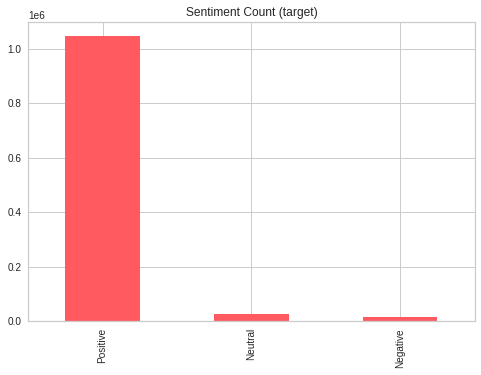

In [4]:
cleaned_df['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title = 'Sentiment Count (target)')

class_positive: (1045528, 14)
class_neutral: (25786, 14)
class_negative: (16185, 14)
Random Under Sampling leads to.........


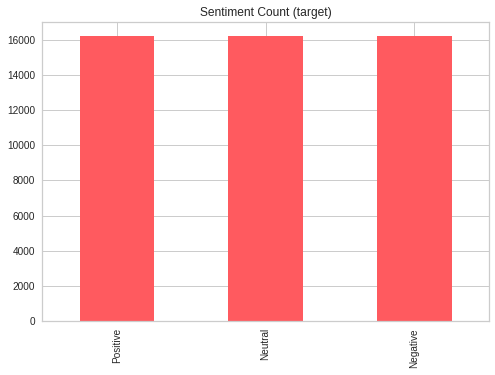

In [5]:
# class count
class_count_positive, class_count_neutral, class_count_negative = cleaned_df['sentiment'].value_counts()


# Separate sentiment into each df
class_positive = cleaned_df[cleaned_df['sentiment'] == "Positive"]
class_neutral = cleaned_df[cleaned_df['sentiment'] == "Neutral"]
class_negative = cleaned_df[cleaned_df['sentiment'] == "Negative"]

print('class_positive:', class_positive.shape)
print('class_neutral:', class_neutral.shape)
print('class_negative:', class_negative.shape)
print("Random Under Sampling leads to.........")
      
# As negative sentiment is the lowest case count, we will do random undersampling for both positive and neutral sentiments to get an equally distributed and balanced dataset
class_positive_under = class_positive.sample(class_count_negative, random_state = RANDOM_SEED)
class_neutral_under = class_neutral.sample(class_count_negative, random_state = RANDOM_SEED)

# Combine all dataframes
cleaned_df_undersampling = pd.concat([class_positive_under, class_neutral_under, class_negative], axis = 0)
cleaned_df_undersampling['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title ='Sentiment Count (target)')

**Split datasets into train, validation and test sets**

We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively.

In [6]:
def get_train_val_test(df, fractions, RANDOM_SEED):

  # Get the required input and target variables from dataframe and drop NA rows:
  df = df[['cleaned_comments','sentiment']].dropna()
  # shuffling the data:
  df = df.sample(frac = 1, random_state = RANDOM_SEED)
  # split into training, validation and testing sets
  train_df, val_df, test_df = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))

  if len(train_df) + len(val_df) + len(test_df) != len(df):
    print("Check the splitting method!")
  else:
    return train_df, val_df, test_df

**Splitting...**

In [7]:
train_df, val_df, test_df = get_train_val_test(cleaned_df_undersampling, fractions, RANDOM_SEED)

**Convert text data to features - TF-IDF and get target input**

In [8]:
%%time
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = min_df, norm ='l2')
X_train = vectorizer.fit_transform(train_df.cleaned_comments)
y_train = list(train_df.sentiment)

CPU times: user 926 ms, sys: 13.8 ms, total: 940 ms
Wall time: 944 ms


**Fit the classifier on the data**

In [9]:
%%time
clf_log = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)
clf_log.fit(X_train, y_train)

CPU times: user 2.69 s, sys: 34.6 ms, total: 2.73 s
Wall time: 2.76 s


LogisticRegression(random_state=42)

**Generate validation data**

In [10]:
%%time
X_val = vectorizer.transform(val_df.cleaned_comments)
y_val = list(val_df.sentiment)

CPU times: user 126 ms, sys: 899 µs, total: 127 ms
Wall time: 129 ms


**Generate logistic regression (baseline model) prediction**

Logistic regression is a good model because it trains quickly even on large datasets and provides very robust results. Other good model choices include SVMs, Random Forests, and Naive Bayes.

In [11]:
%%time
lr_pred = clf_log.predict(X_val)
lr_f1 = f1_score(y_val, lr_pred, average = 'macro')
print("F1 score for baseline regression:", lr_f1)

F1 score for baseline regression: 0.9013962556143239
CPU times: user 24.9 ms, sys: 815 µs, total: 25.7 ms
Wall time: 25 ms


**Comparing all classification models**

In [12]:
clf_log = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)
clf_svm = svm.SVC(decision_function_shape = 'ovr', probability = True, random_state = RANDOM_SEED)
clf_svm_ = svm.SVC(decision_function_shape = 'ovr', random_state = RANDOM_SEED) # without probability = True
clf_nb = MultinomialNB()
clf_dt = tree.DecisionTreeClassifier(random_state = RANDOM_SEED)
clf_rf = RandomForestClassifier(random_state = RANDOM_SEED)
clf_gbc = GradientBoostingClassifier(random_state = RANDOM_SEED)
clf_boost = AdaBoostClassifier(random_state = RANDOM_SEED)
clf_xtratree = ExtraTreesClassifier(random_state = RANDOM_SEED)
clf_knn = KNeighborsClassifier(n_neighbors = k)

model_names = ["LogisticRegression (Base)", "SupportVectorMachine", "MultinomialNB", "DecisionTreeClassifier", 
               "RandomForestClassifier", "GradientBoostingClassifier", "AdaBoostClassifier", "ExtraTreesClassifier", "KNeighborsClassifier"]

model_list = [clf_log, clf_svm, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]
model_list_ = [clf_log, clf_svm_, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]

In [13]:
accuracy = []
precision = []
recall = []
f1score = []
jaccard = []
fbeta = []
roc_auc = []
logloss_ = []

for model in tqdm(model_list):
  model.fit(X_train, y_train)
  model_predict = model.predict(X_val)
  accuracy.append(accuracy_score(model_predict, y_val))
  precision.append(precision_score(model_predict, y_val, average = 'macro'))
  recall.append(recall_score(model_predict, y_val, average = 'macro'))
  f1score.append(f1_score(model_predict, y_val, average = 'macro'))
  jaccard.append(jaccard_score(model_predict, y_val, average = 'macro'))
  fbeta.append(fbeta_score(model_predict, y_val, average = 'macro', beta = 0.5))
  roc_auc.append(roc_auc_score(y_val, model.predict_proba(X_val), multi_class = 'ovr', average = 'macro'))
  logloss_.append(log_loss(y_val, model.predict_proba(X_val)))

100%|██████████| 9/9 [34:25<00:00, 229.53s/it]


In [14]:
pd.DataFrame(list(zip(model_names, accuracy, precision, recall, f1score, jaccard, fbeta, roc_auc, logloss_)),
               columns =['Classifier', 'Accuracy (Balanced)', 'Precision', 'Recall', 'F1 Score', 'Jaccard Score', 'F-beta Score', 'AUC ROC Score', 'Log Loss'])

,Classifier,Accuracy (Balanced),Precision,Recall,F1 Score,Jaccard Score,F-beta Score,AUC ROC Score,Log Loss
0,LogisticRegression (Base),0.901507,0.901621,0.901330,0.901396,0.821230,0.901512,0.974316,0.305532
1,SupportVectorMachine,0.901714,0.901764,0.902597,0.902046,0.822424,0.901844,0.973954,0.301044
2,MultinomialNB,0.799091,0.796940,0.831362,0.793385,0.659110,0.791628,0.963060,0.455257
3,DecisionTreeClassifier,0.824076,0.824596,0.823508,0.823947,0.703934,0.824312,0.854758,5.816378
4,RandomForestClassifier,0.887879,0.888035,0.888094,0.888063,0.799858,0.888046,0.965764,0.398524
5,GradientBoostingClassifier,0.860004,0.860299,0.859694,0.859733,0.755196,0.860008,0.958039,0.453209
6,AdaBoostClassifier,0.823457,0.824156,0.829185,0.819004,0.697793,0.820304,0.846559,1.023109
7,ExtraTreesClassifier,0.890770,0.890869,0.891503,0.891137,0.804867,0.890965,0.966450,0.456159
8,KNeighborsClassifier,0.434028,0.438598,0.617712,0.366581,0.236003,0.381910,0.595797,17.506703


**ROC-AUC Curve plots**

In [15]:
def plot_ROC_curve(model, X_train, y_train, X_val, y_val):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder = {'Positive': 'Positive', 
                                          'Neutral': 'Neutral', 
                                          'Negative': 'Negative'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_val, y_val)
    visualizer.show()
    
    return visualizer

  0%|          | 0/9 [00:00<?, ?it/s]

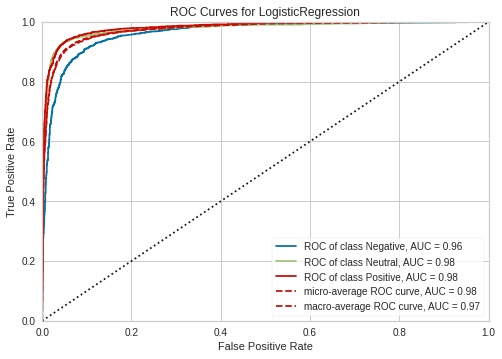

 11%|█         | 1/9 [00:00<00:02,  3.02it/s]

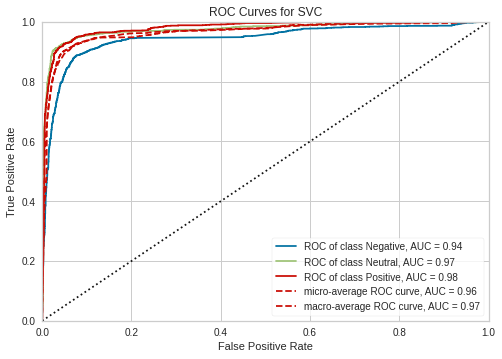

 22%|██▏       | 2/9 [07:00<28:51, 247.41s/it]

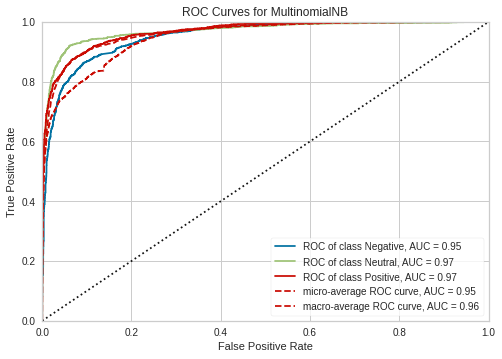

 33%|███▎      | 3/9 [07:00<13:27, 134.57s/it]

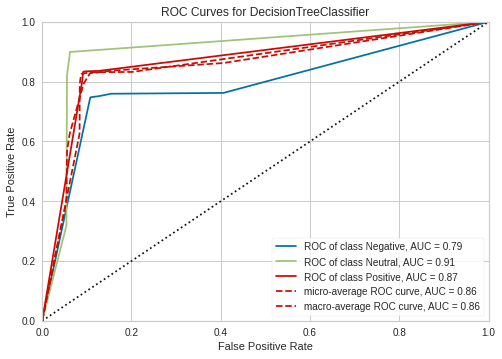

 44%|████▍     | 4/9 [07:01<06:48, 81.65s/it] 

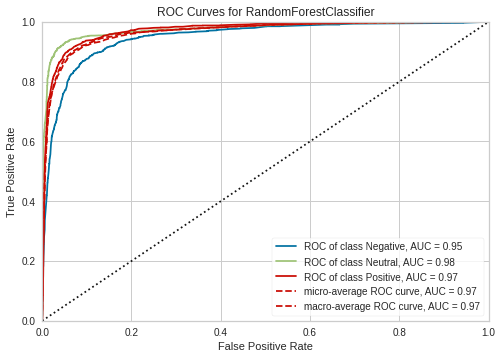

 56%|█████▌    | 5/9 [07:02<03:30, 52.56s/it]

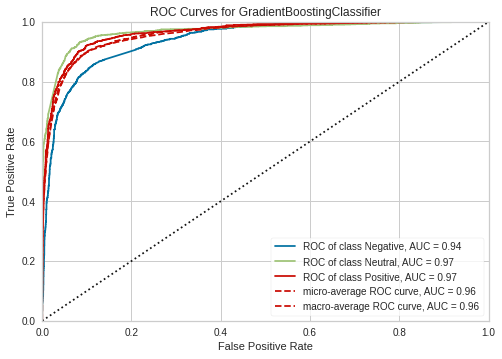

 67%|██████▋   | 6/9 [07:02<01:44, 34.81s/it]

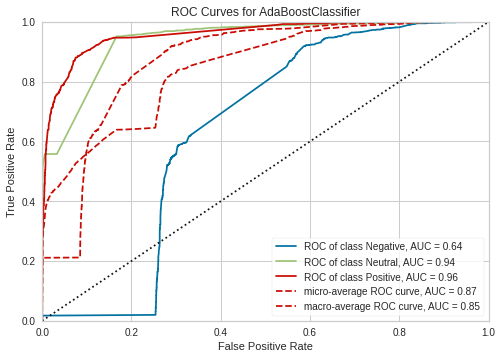

 78%|███████▊  | 7/9 [07:03<00:47, 23.57s/it]

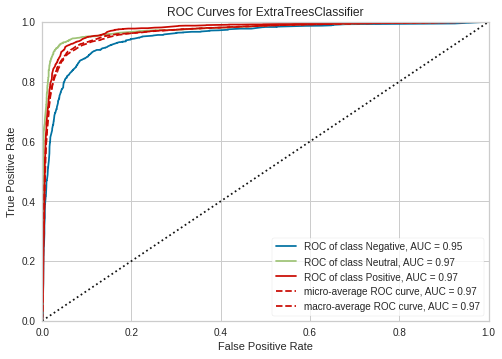

 89%|████████▉ | 8/9 [07:04<00:16, 16.49s/it]

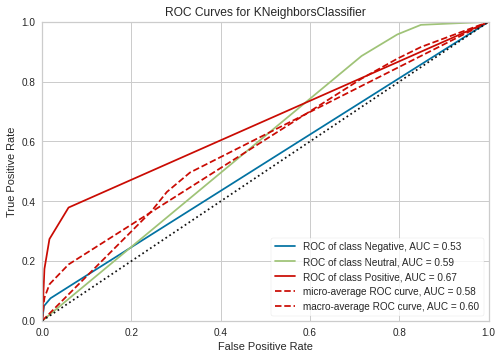

100%|██████████| 9/9 [07:16<00:00, 48.52s/it]


In [16]:
for model in tqdm(model_list_):
  plot_ROC_curve(model, X_train, y_train, X_val, y_val)

In [17]:
def plot_Confusion_Matrix_Heatmap(model, X_train, y_train, X_val, y_val):

    classes = ['Positive', 'Neutral', 'Negative']
    visualizer = ConfusionMatrix(
        model, classes = classes,
        percent = True,
        label_encoder = {'Positive': 'Positive', 
                         'Neutral': 'Neutral', 
                         'Negative': 'Negative'})

    visualizer.fit(X_train, y_train)
    visualizer.score(X_val, y_val)
    visualizer.show()
    
    return visualizer

  0%|          | 0/9 [00:00<?, ?it/s]

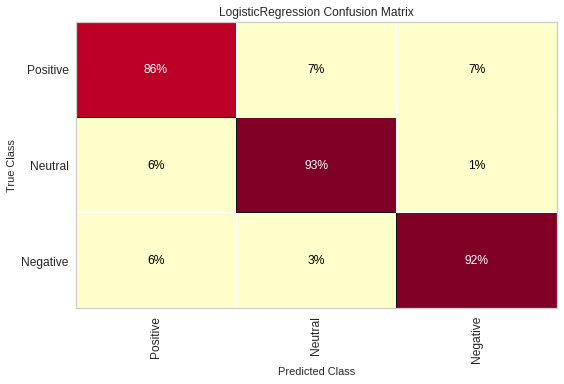

 11%|█         | 1/9 [00:00<00:01,  4.21it/s]

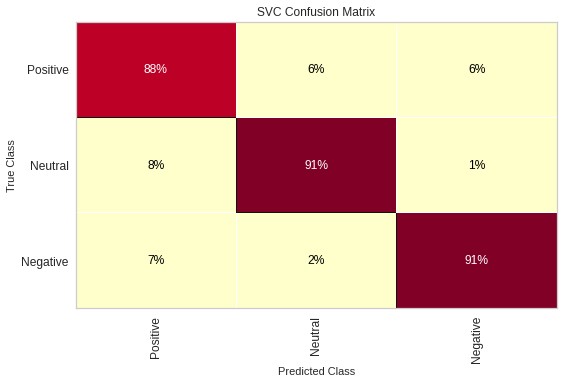

 22%|██▏       | 2/9 [00:29<01:59, 17.07s/it]

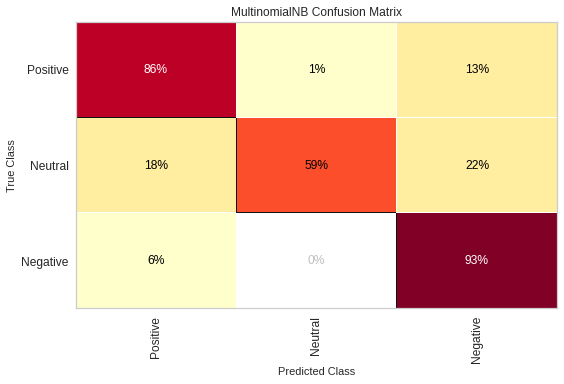

 33%|███▎      | 3/9 [00:29<00:56,  9.37s/it]

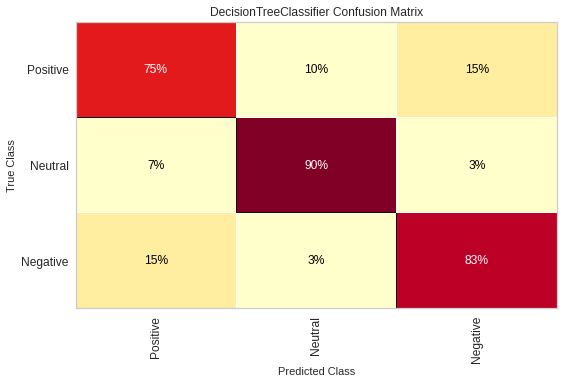

 44%|████▍     | 4/9 [00:29<00:28,  5.76s/it]

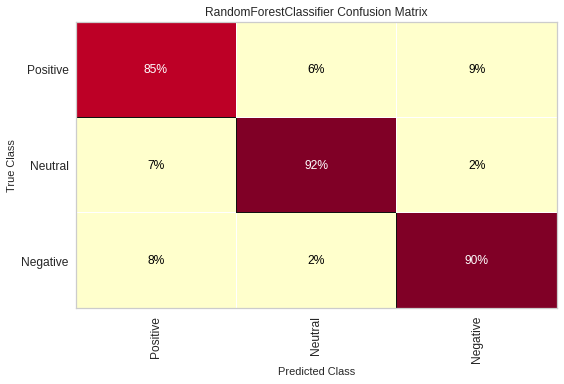

 56%|█████▌    | 5/9 [00:30<00:15,  3.98s/it]

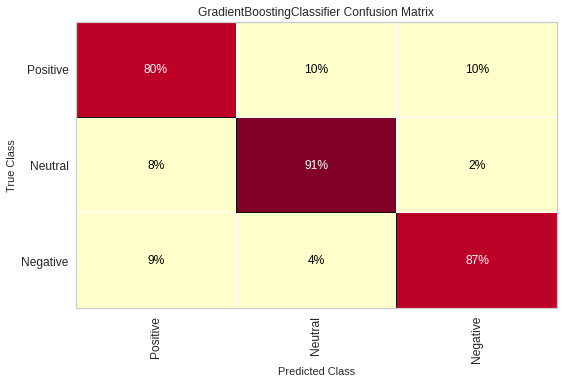

 67%|██████▋   | 6/9 [00:30<00:08,  2.71s/it]

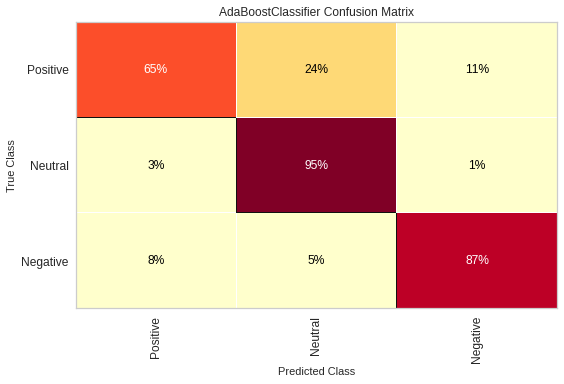

 78%|███████▊  | 7/9 [00:30<00:03,  1.94s/it]

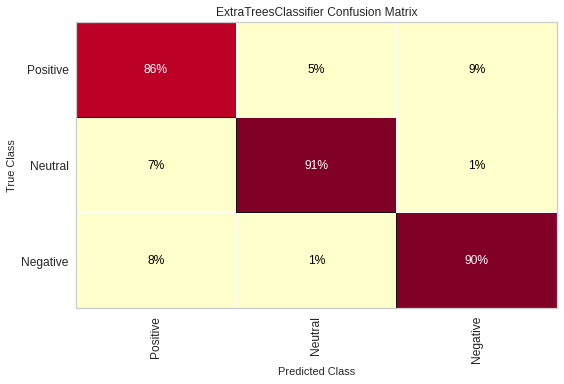

 89%|████████▉ | 8/9 [00:32<00:01,  1.67s/it]

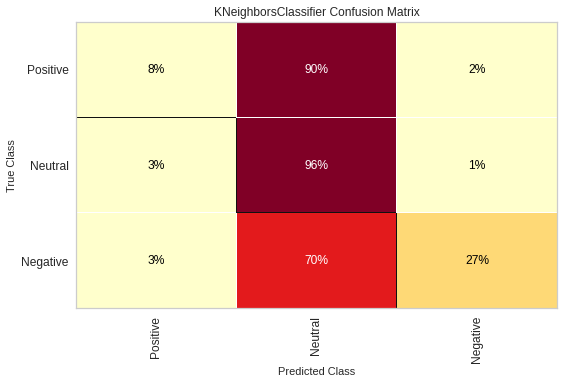

100%|██████████| 9/9 [00:42<00:00,  4.73s/it]


In [18]:
for model in tqdm(model_list_):
  plot_Confusion_Matrix_Heatmap(model, X_train, y_train, X_val, y_val)

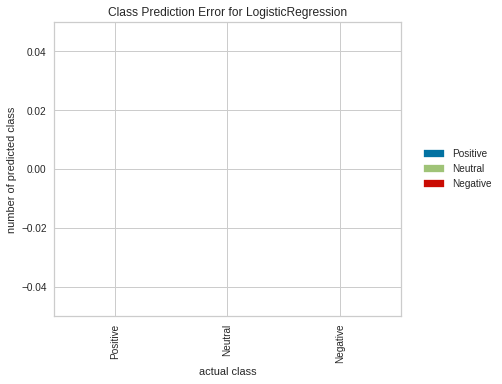

In [19]:
from yellowbrick.classifier import ClassPredictionError
classes = ['Positive', 'Neutral', 'Negative']
visualizer = ClassPredictionError(
    clf_log, classes = classes,
        percent = True,
        label_encoder = {'Positive': 'Positive', 
                         'Neutral': 'Neutral', 
                         'Negative': 'Negative'})
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show();

**Hyperparameter Tuning**